[View in Colaboratory](https://colab.research.google.com/github/redpanda-ai/deep-learning/blob/master/20180906_object_detection_with_tensorflow.ipynb)

In [1]:
import cv2
print(cv2.__version__)

3.4.2


# Links
- source: [Detection using Tensorflow Gist](https://gist.github.com/copperwiring/86b1b7114e4676c60d9e6c7cdaef1262)

- [Tensorflow Object Detection Tutorial](https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb)

# What is Tensorflow?
Deep learning Framework from Google
It is an open source library for numerical computation using data flow graphs.

- In tensorflow, a model is represented as a data flow graph
- Nodes - **operations** which have any number of input and output
- Edges - **tensors** which flow between nodes
- Each operation takes input a tensor and output a tensor
- Tensor is how a data is represted in tensorflow
- They are multidimensional arrays of numbers that flow between operations --> Tensorflow


# Step 1
**Object Detection API configuration:** In this step the model for object detection is downloaded.

In [1]:
!git clone https://github.com/tensorflow/models.git
!apt-get -qq install libprotobuf-java protobuf-compiler
!protoc ./models/research/object_detection/protos/string_int_label_map.proto --python_out=.
!cp -R models/research/object_detection/ object_detection/
!rm -rf models

Cloning into 'models'...
remote: Counting objects: 21671, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 21671 (delta 0), reused 0 (delta 0), pack-reused 21665
Receiving objects: 100% (21671/21671), 558.49 MiB | 15.65 MiB/s, done.
Resolving deltas: 100% (12779/12779), done.
Checking out files: 100% (2670/2670), done.
Selecting previously unselected package libprotobuf10:amd64.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../libprotobuf10_3.0.0-9ubuntu5_amd64.deb ...
Unpacking libprotobuf10:amd64 (3.0.0-9ubuntu5) ...
Selecting previously unselected package libprotoc10:amd64.
Preparing to unpack .../libprotoc10_3.0.0-9ubuntu5_amd64.deb ...
Unpacking libprotoc10:amd64 (3.0.0-9ubuntu5) ...
Selecting previously unselected package libprotobuf-java.
Preparing to unpack .../libprotobuf-java_3.0.0-9ubuntu5_all.deb ...
Unpacking libprotobuf-java (3.0.0-9ubuntu5) ...
Selecting previously unselected package protobuf-compiler.
Prep

# Step 2
**Imports** neeed to run the Object Detection API demonstration

In [2]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt

from PIL import Image

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

/content/object_detection/utils/visualization_utils.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "<decorator-gen-121>", line 2, in initialize
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 87, in catch_config_error
    retu

# Step 3
**Configuration** of the model to use, path to the frozen inference graph  and  extra config elements for the Object Detection API implementation.

In [0]:
# What model to download.
# MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'

# model with more accurancy but up to you use a diferent model
MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous_coco_2017_11_08'

MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('object_detection/data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

## Download Model
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())
    
## Load a (frozen) Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
### Loading label map
# Label maps map indices to category names, Example, so that when our conolutional network predicts '5', we know that this corresponds to 'airp'
# Here we use internal utility functions but anything that returns a dictionary mapping integers to appropriate string labels would be fine
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [0]:
## the array based representations of the image will be used later in order to prepare the
## result image with boxes and labels on it.
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

- We want to get rid of unnnecessary metadata, gradients and unnecessary training variables and encapsulate it all in a single file.
- This single encapsulated file (.pb extnsion) is called "**frozen graph def**"".
site: tensorflow.org/mobile/prepare_models

# Step 4
**Working with our data**

In [0]:
!mkdir images

In [5]:
!wget https://img.cutenesscdn.com/640/photos.demandstudios.com/getty/article/225/225/478872471.jpg -O images/custom_img_1.jpg


Redirecting output to ‘wget-log’.


In [6]:
!wget https://s.aolcdn.com/dims-global/dims3/GLOB/legacy_thumbnail/916x515/quality/95/https://s.blogcdn.com/slideshows/images/slides/727/101/1/S7271011/slug/l/01-2019-mercedes-benz-cls450-fd-1.jpg -O images/custom_img_2.jpg


Redirecting output to ‘wget-log.1’.


In [7]:
!ls ./images/

custom_img_1.jpg  custom_img_2.jpg


In [0]:
PATH_TO_TEST_IMAGES_DIR = 'images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'custom_img_{}.jpg'.format(i)) for i in range(1, 3) ]

IMAGE_SIZE = (12, 8)

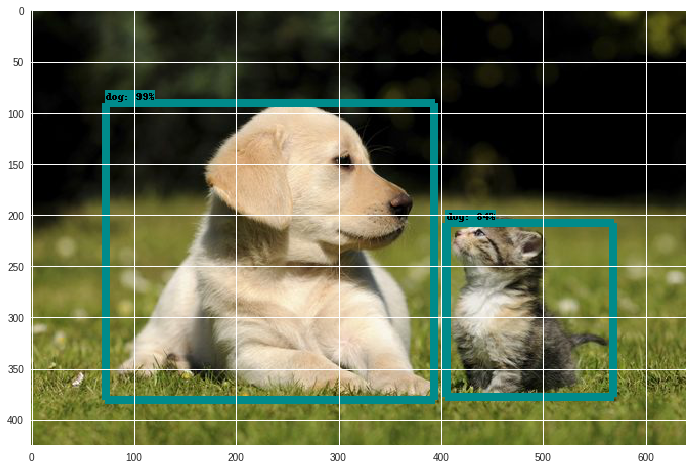

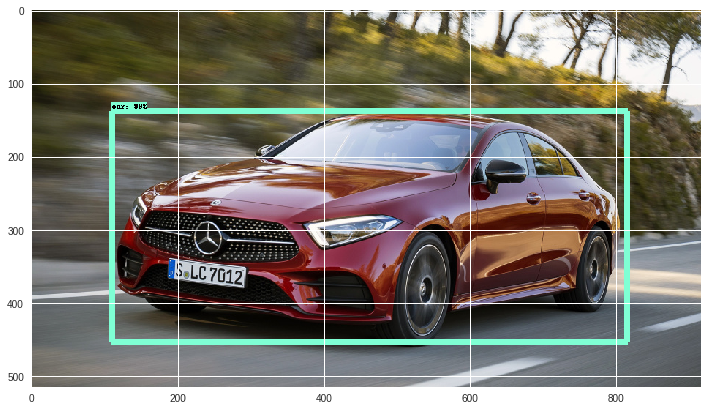

In [12]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    
    ## Each box represents a part of the image where a particular object was detected
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    
    ## Each score represents how level of confidence for each of the objects
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open(image_path)
      image_np = load_image_into_numpy_array(image)
      image_np_expanded = np.expand_dims(image_np, axis=0)
      
      ## Each score represent how level of confidence for each of the objects.
      
      (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      
      # Visualization of the results of a detection.
      
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=8)
      
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)

# Step 5